# Project to predict customer attrition for a Telecommunications company.

The goal of this project is to be able to build a machine learning model that will be able to predict the churn of customers for a telecommunications company. The goal is to be able to identify if there are possible indicators that result in the customers churning and propose possible remedies to prevent attrition of the customers.

### Hypothesis
##### Null Hypothesis: 
The contract term has no effect on the churn rate.
##### Alternative Hypothesis: 
The churn rate varies significantly depending on the contract term

#### Analytical questions:
1. What is the comparison of the number of customers who have churned against those who were retained.
2. Is there a relation between the contract type and the customer churn rate
3. What is the relation between the tenure and the churn for the customers
4. Is there a relation between gender and the churn rate
5. Does the customer having a partner and dependents affect the churn rate?
6. What is the longest period of time we have had a customer?
7. What is the relationship between tenure and Churn?

In [1]:
#%pip install pyodbc
#%pip install python-dotenv
#%pip install scikit-learn
#%pip install --user imbalanced-learn scikit-learn




In [2]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,OrdinalEncoder
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')




In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('credentials.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USER")
password = environment_variables.get("PASSWORD")

In [4]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
# Establishing connection to database.
connection = pyodbc.connect(connection_string)

In [5]:
#Getting the data from the server
query = "SELECT * FROM LP2_Telco_churn_first_3000"
dataset_1 = pd.read_sql(query, connection)

In [6]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [7]:
#Getting the second data set.
dataset_2= pd.read_csv('Data_Source/Dataset_2.csv')

In [8]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [9]:
#Getting the third data set
dataset_3 = pd.read_excel('Data_Source/Telco-churn-last-2000.xlsx')

In [10]:
#Concatenating dataset_1 & dataset_2 for EDA.
dataset = pd.concat([dataset_1, dataset_2], axis=0, ignore_index=True)

In [11]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [12]:
dataset.shape

(5043, 21)

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [14]:
#Drop the customerID column as it doesnt have info needed for our model.
dataset = dataset.drop('customerID', axis=1)


In [15]:
#Convert the TotalCharges column to float to be able to get 
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [16]:
dataset.columns.values

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

<function matplotlib.pyplot.show(close=None, block=None)>

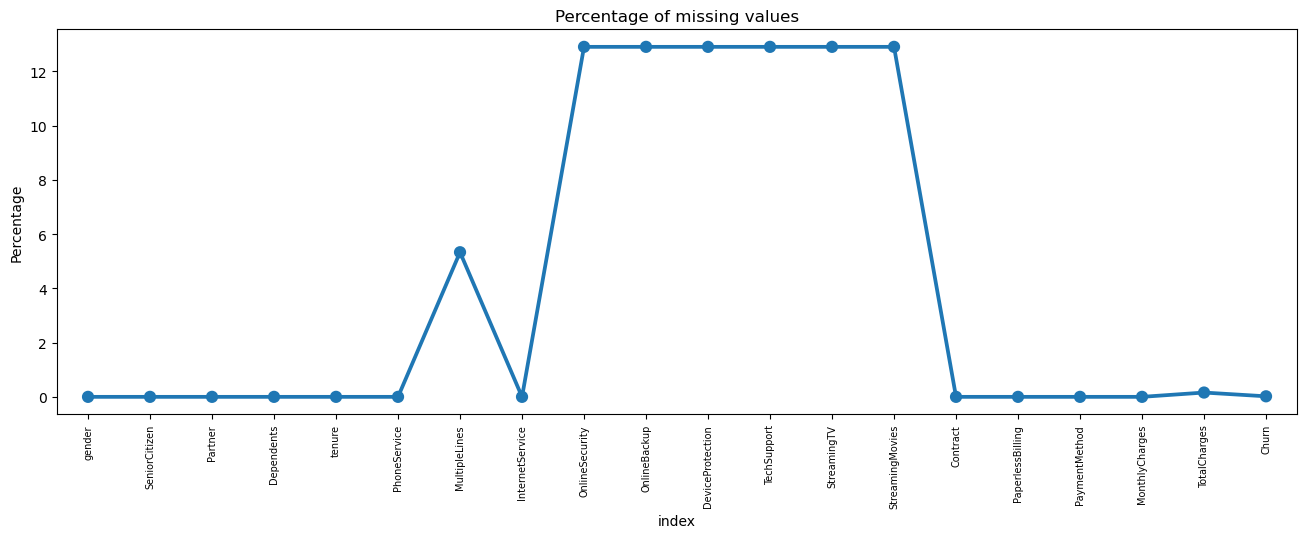

In [17]:
#Check for the percentage of null values for each column.

missing = pd.DataFrame((dataset.isnull().sum())*100/dataset.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index', y=0, data = missing)
plt.xticks(rotation = 90, fontsize = 7)
plt.title("Percentage of missing values")
plt.ylabel("Percentage")
plt.show

From this, we can see the columns that have missing values.
They are the:
Categorical values- MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingMovies
TotalCharges & Churn also have missing values. 

In the dataset, we do realize that the concatenated dataset has columns that have two different values that stand for the same thing. Map out the data to have consistent values for ease of processing.

In [18]:
#Function mapping out the various differences in the dataset.
mapping={'No internet service': 'No','DSL':'Yes','Fiber optic' : 'Yes', True: 'Yes', False: 'No', None: 'No', 'No phone service': 'No'}
for column in dataset.columns:
    dataset[column] = dataset[column].replace(mapping)

In [19]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No,Yes,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,No,No,No,34,Yes,No,Yes,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,No,No,No,2,Yes,No,Yes,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,No,No,No,45,No,No,Yes,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,Female,No,No,No,2,Yes,No,Yes,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


In [20]:
#Getting the statistics for columns with numerical values in the dataset.
dataset.describe()

,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5035.000000
mean,32.576641,65.090214,2302.062861
std,24.529807,30.068133,2269.483576
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,417.675003
50%,29.000000,70.550003,1401.150024
75%,56.000000,90.050003,3862.000000
max,72.000000,118.650002,8670.100000


#### Insight Derived:
75% of the customers have a tenure of less than 56 months.

The average monthly charge of for the customer is 65.090$.

The highest monthly charge is 118.65$ while 25% of the customers pay above 90.05$

The minimum monthly charge is 18.4$.

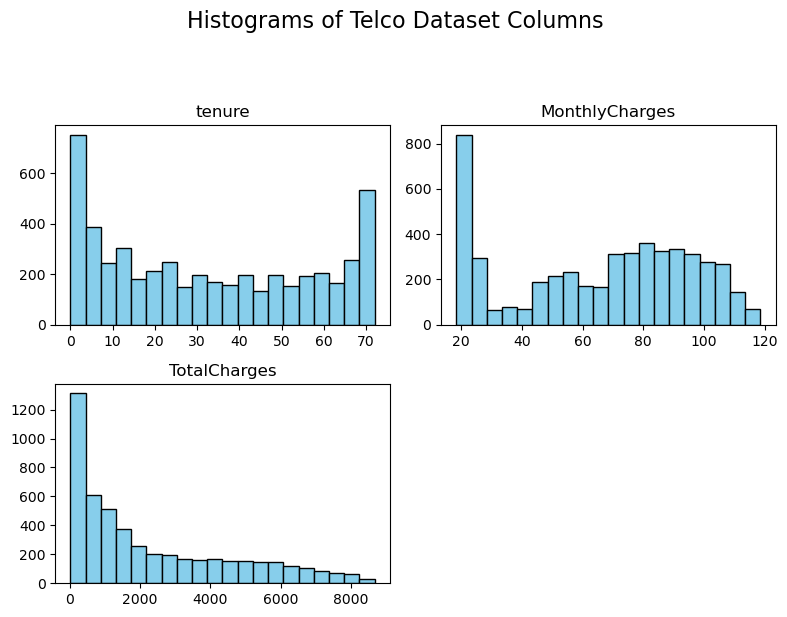

In [21]:
# Plot histograms for all columns
axes=dataset.hist(figsize=(8, 6), bins=20, color='skyblue', edgecolor='black')

# Set plot labels and title
plt.suptitle("Histograms of Telco Dataset Columns", y=1.02, size=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
for ax in axes.flatten():
    ax.grid(False)

# Display the plot
plt.show()

## Exploratory Data Analysis.
#### Univariate Analysis.


Analysis of the various distribution of the data across various entries as below.



**Univariate Analysis of Feature: gender**
count     5043
unique       2
top       Male
freq      2559
Name: gender, dtype: object

Unique Values and Counts:
gender
Male      2559
Female    2484
Name: count, dtype: int64

Missing Values: 0 (0.00%)


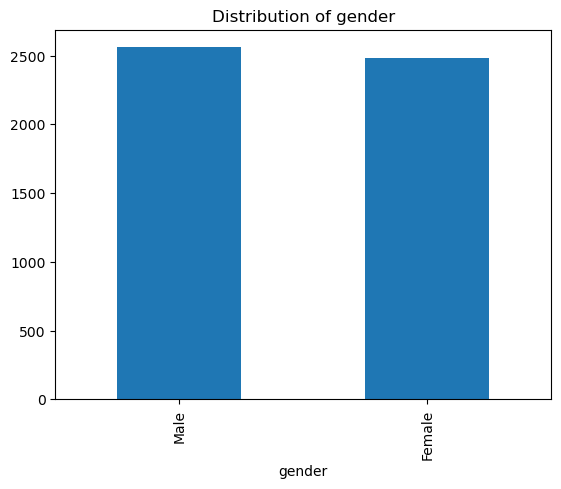


**Univariate Analysis of Feature: SeniorCitizen**
count     5043
unique       2
top         No
freq      4224
Name: SeniorCitizen, dtype: object

Unique Values and Counts:
SeniorCitizen
No     4224
Yes     819
Name: count, dtype: int64

Missing Values: 0 (0.00%)


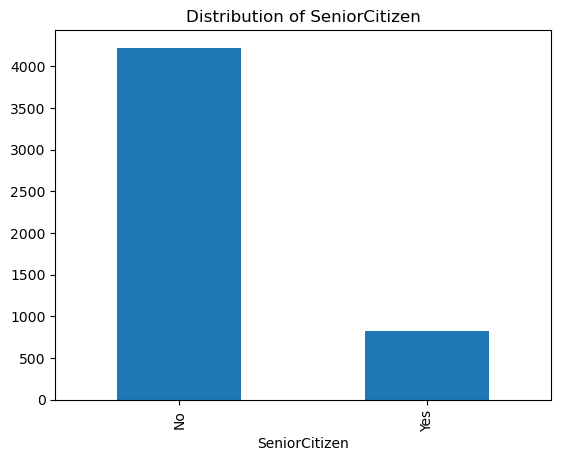


**Univariate Analysis of Feature: Partner**
count     5043
unique       2
top         No
freq      2585
Name: Partner, dtype: object

Unique Values and Counts:
Partner
No     2585
Yes    2458
Name: count, dtype: int64

Missing Values: 0 (0.00%)


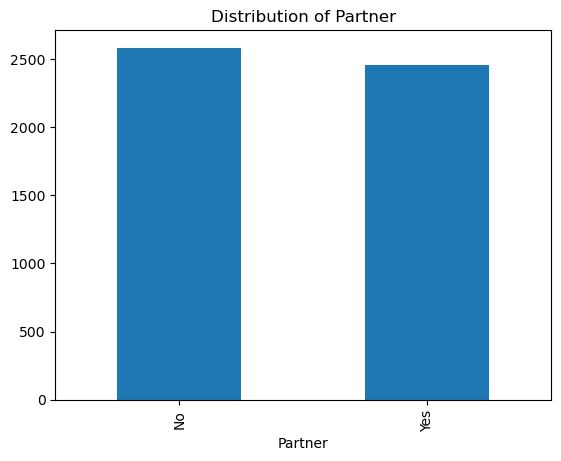


**Univariate Analysis of Feature: Dependents**
count     5043
unique       2
top         No
freq      3482
Name: Dependents, dtype: object

Unique Values and Counts:
Dependents
No     3482
Yes    1561
Name: count, dtype: int64

Missing Values: 0 (0.00%)


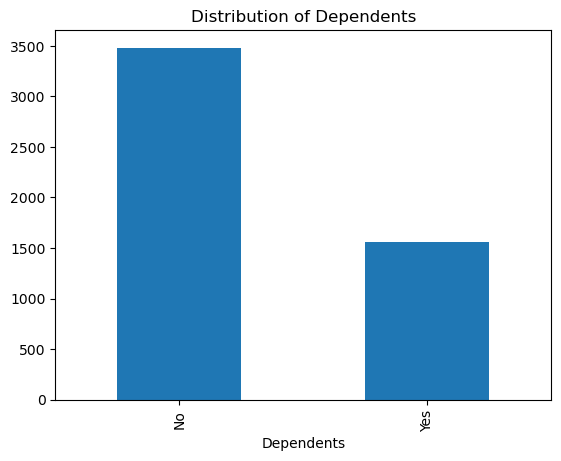


**Univariate Analysis of Feature: PhoneService**
count     5043
unique       2
top        Yes
freq      4554
Name: PhoneService, dtype: object

Unique Values and Counts:
PhoneService
Yes    4554
No      489
Name: count, dtype: int64

Missing Values: 0 (0.00%)


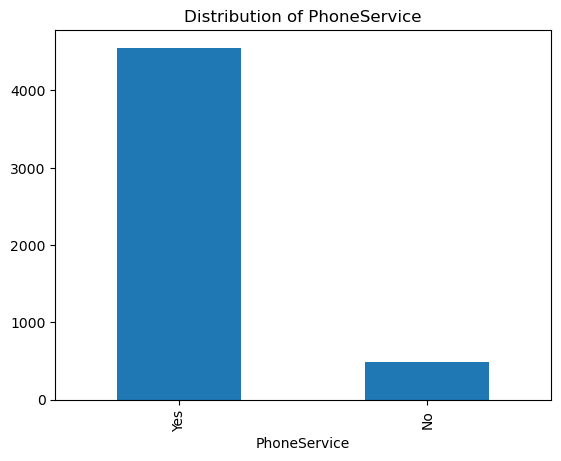


**Univariate Analysis of Feature: MultipleLines**
count     5043
unique       2
top         No
freq      2913
Name: MultipleLines, dtype: object

Unique Values and Counts:
MultipleLines
No     2913
Yes    2130
Name: count, dtype: int64

Missing Values: 0 (0.00%)


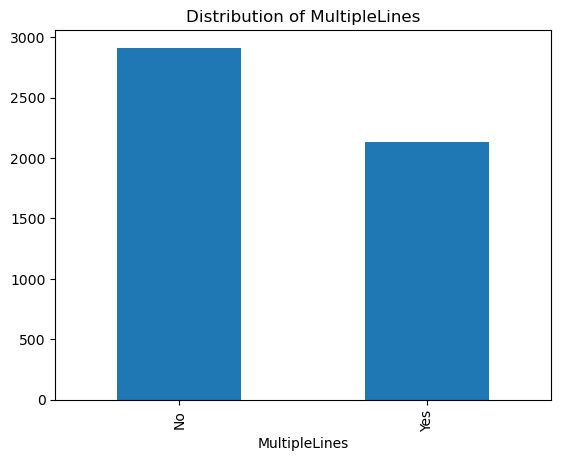


**Univariate Analysis of Feature: InternetService**
count     5043
unique       2
top        Yes
freq      3963
Name: InternetService, dtype: object

Unique Values and Counts:
InternetService
Yes    3963
No     1080
Name: count, dtype: int64

Missing Values: 0 (0.00%)


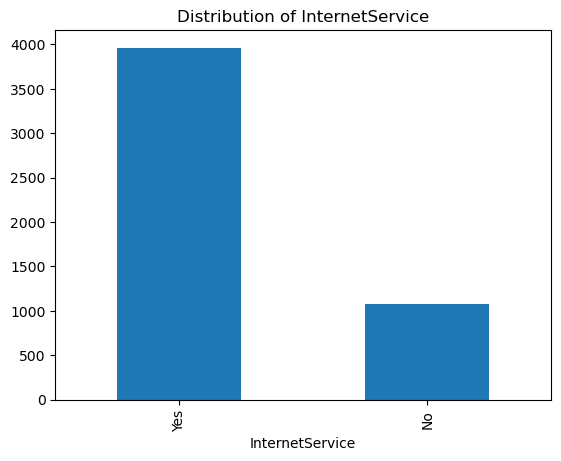


**Univariate Analysis of Feature: OnlineSecurity**
count     5043
unique       2
top         No
freq      3587
Name: OnlineSecurity, dtype: object

Unique Values and Counts:
OnlineSecurity
No     3587
Yes    1456
Name: count, dtype: int64

Missing Values: 0 (0.00%)


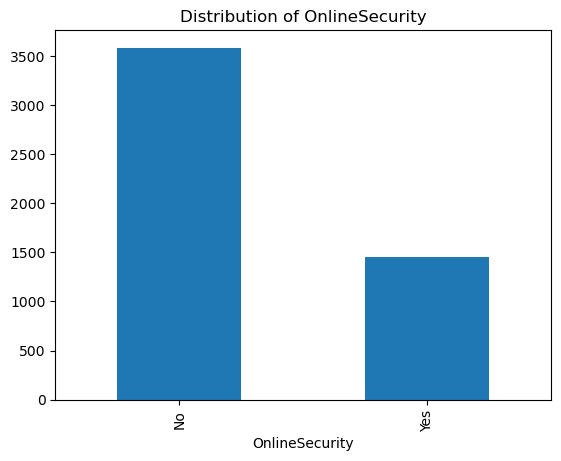


**Univariate Analysis of Feature: OnlineBackup**
count     5043
unique       2
top         No
freq      3311
Name: OnlineBackup, dtype: object

Unique Values and Counts:
OnlineBackup
No     3311
Yes    1732
Name: count, dtype: int64

Missing Values: 0 (0.00%)


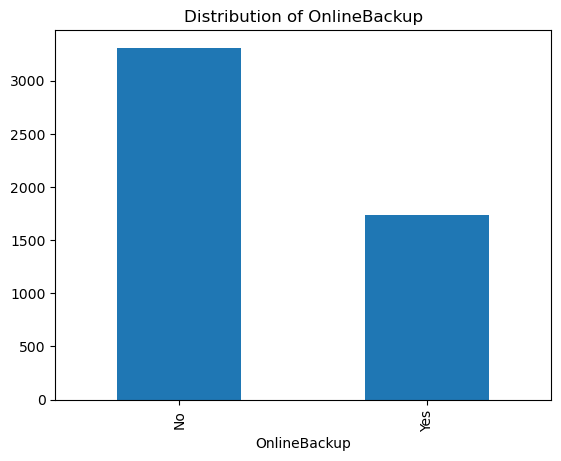


**Univariate Analysis of Feature: DeviceProtection**
count     5043
unique       2
top         No
freq      3299
Name: DeviceProtection, dtype: object

Unique Values and Counts:
DeviceProtection
No     3299
Yes    1744
Name: count, dtype: int64

Missing Values: 0 (0.00%)


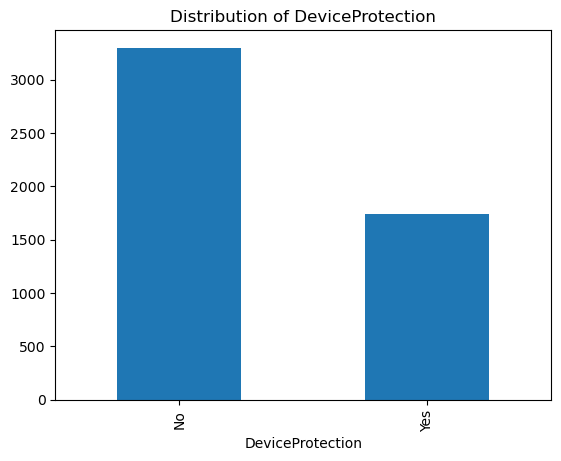


**Univariate Analysis of Feature: TechSupport**
count     5043
unique       2
top         No
freq      3552
Name: TechSupport, dtype: object

Unique Values and Counts:
TechSupport
No     3552
Yes    1491
Name: count, dtype: int64

Missing Values: 0 (0.00%)


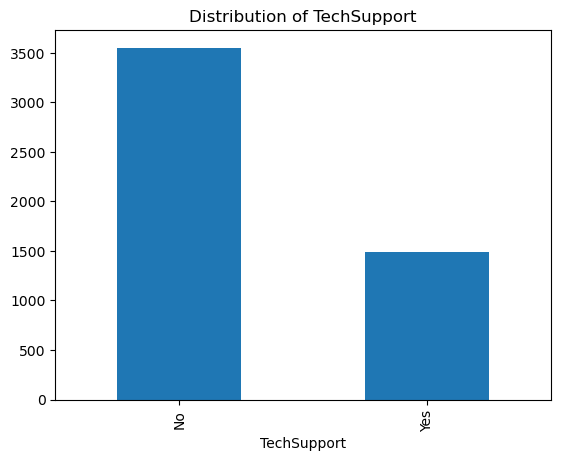


**Univariate Analysis of Feature: StreamingTV**
count     5043
unique       2
top         No
freq      3098
Name: StreamingTV, dtype: object

Unique Values and Counts:
StreamingTV
No     3098
Yes    1945
Name: count, dtype: int64

Missing Values: 0 (0.00%)


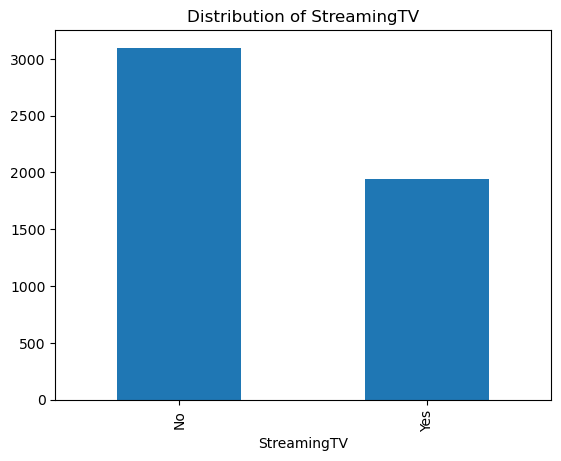


**Univariate Analysis of Feature: StreamingMovies**
count     5043
unique       2
top         No
freq      3061
Name: StreamingMovies, dtype: object

Unique Values and Counts:
StreamingMovies
No     3061
Yes    1982
Name: count, dtype: int64

Missing Values: 0 (0.00%)


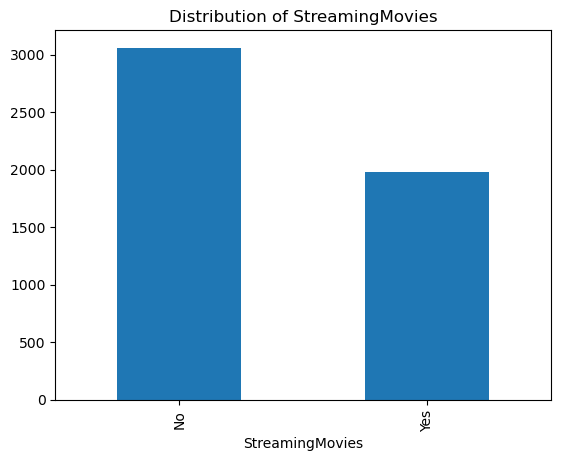


**Univariate Analysis of Feature: Contract**
count               5043
unique                 3
top       Month-to-month
freq                2744
Name: Contract, dtype: object

Unique Values and Counts:
Contract
Month-to-month    2744
Two year          1244
One year          1055
Name: count, dtype: int64

Missing Values: 0 (0.00%)


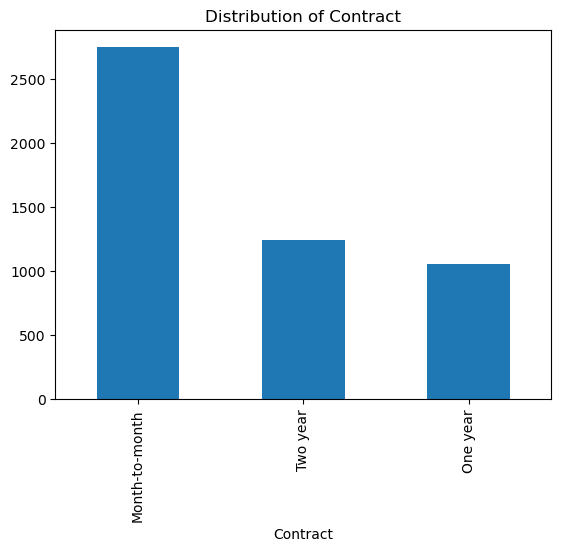


**Univariate Analysis of Feature: PaperlessBilling**
count     5043
unique       2
top        Yes
freq      2996
Name: PaperlessBilling, dtype: object

Unique Values and Counts:
PaperlessBilling
Yes    2996
No     2047
Name: count, dtype: int64

Missing Values: 0 (0.00%)


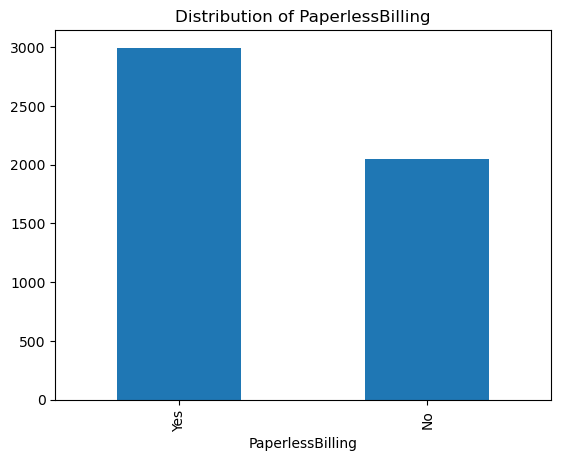


**Univariate Analysis of Feature: PaymentMethod**
count                 5043
unique                   4
top       Electronic check
freq                  1700
Name: PaymentMethod, dtype: object

Unique Values and Counts:
PaymentMethod
Electronic check             1700
Mailed check                 1128
Bank transfer (automatic)    1125
Credit card (automatic)      1090
Name: count, dtype: int64

Missing Values: 0 (0.00%)


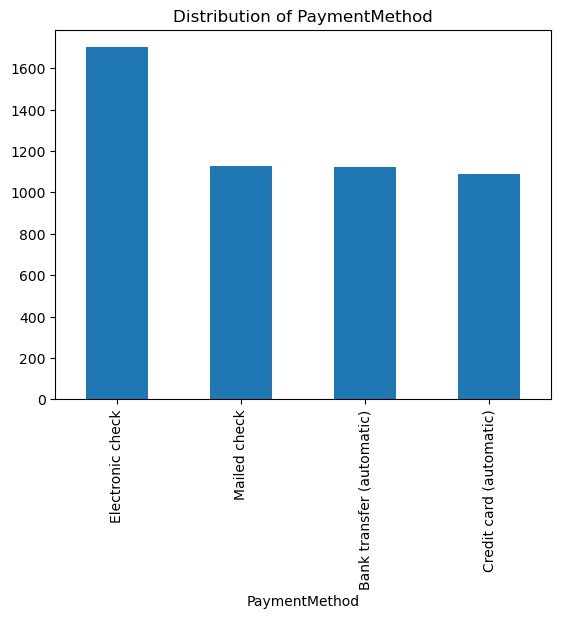


**Univariate Analysis of Feature: Churn**
count     5043
unique       2
top         No
freq      3707
Name: Churn, dtype: object

Unique Values and Counts:
Churn
No     3707
Yes    1336
Name: count, dtype: int64

Missing Values: 0 (0.00%)


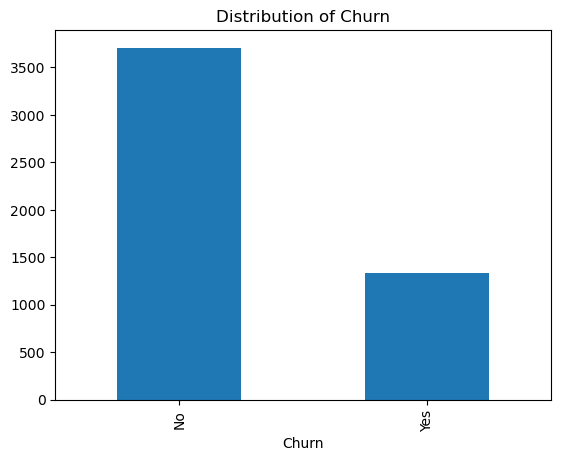

In [22]:
# List of categorical variables
categorical_features = list(dataset.select_dtypes(include=["object"]))

# Loop through each categorical variable
for feature in categorical_features:
    # Describe the feature
    print(f"\n**Univariate Analysis of Feature: {feature}**")
    print(dataset[feature].describe())

    # Print the number of unique values and their corresponding counts
    print("\nUnique Values and Counts:")
    print(dataset[feature].value_counts())

    # Calculate and print the percentage of missing values
    missing_values_count = dataset[feature].isnull().sum()
    missing_values_percentage = (missing_values_count / len(dataset)) * 100
    print(f"\nMissing Values: {missing_values_count} ({missing_values_percentage:.2f}%)")

    # Plot the distribution of the variable
    dataset[feature].value_counts().plot(kind="bar")
    plt.xlabel(feature)
    plt.title(f"Distribution of {feature}")
    plt.show()

### Bi-Variate Analysis

In [23]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(0, 73, 12)]

dataset['tenure_group'] = pd.cut(dataset.tenure, range(0, 96, 12), right=False, labels=labels)

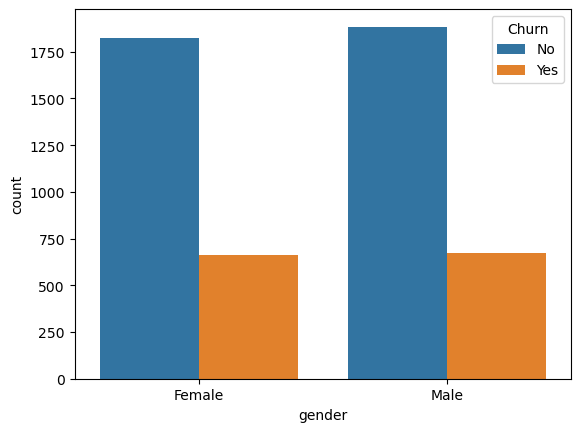

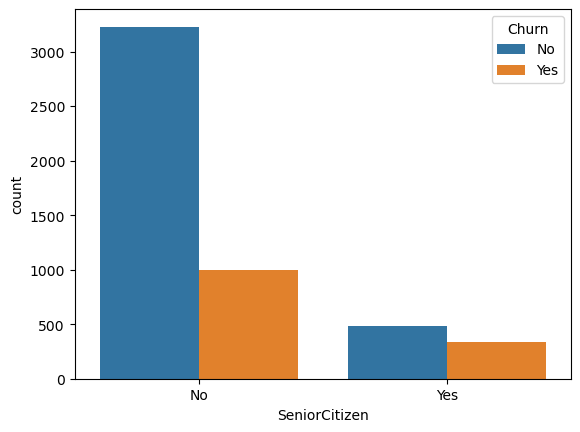

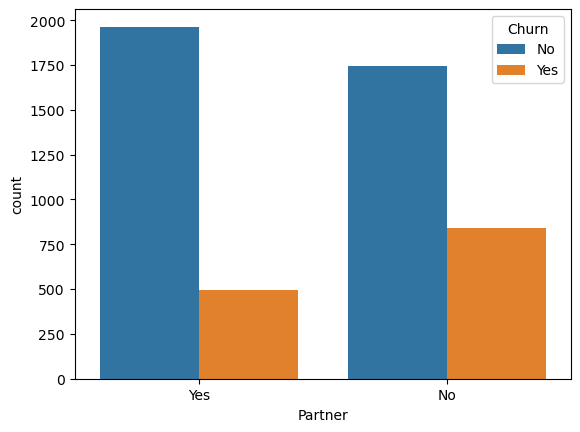

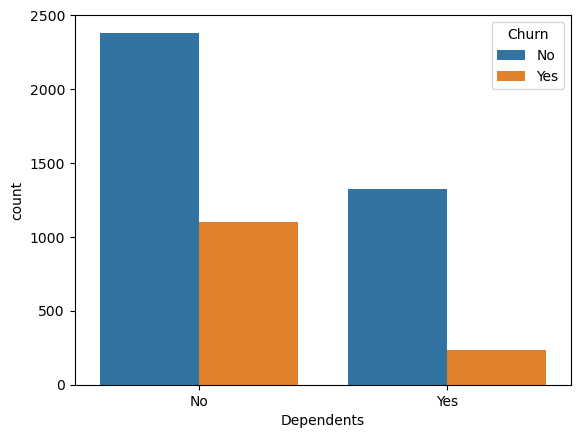

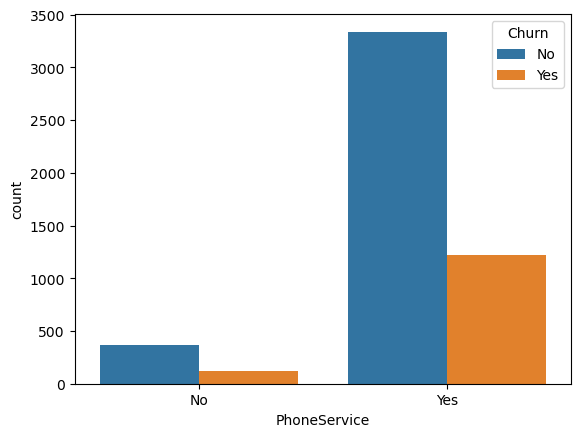

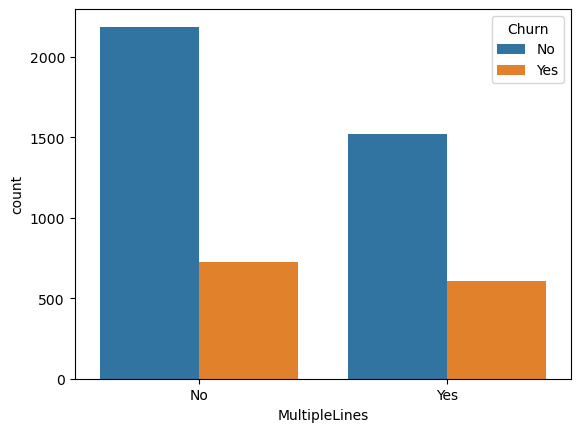

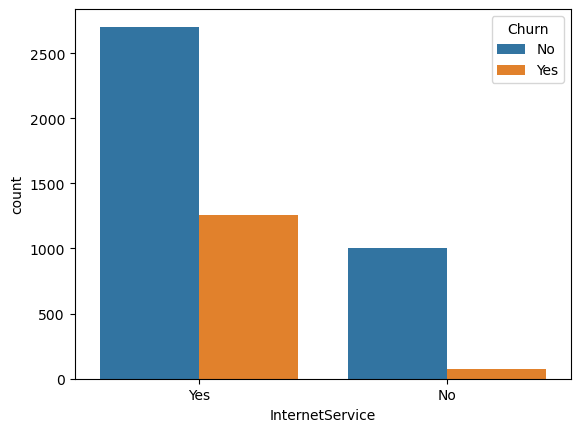

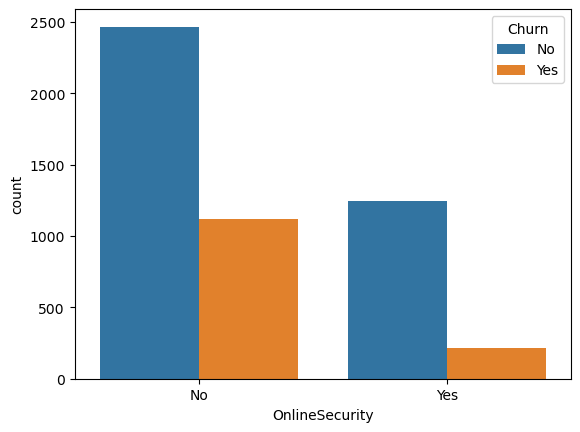

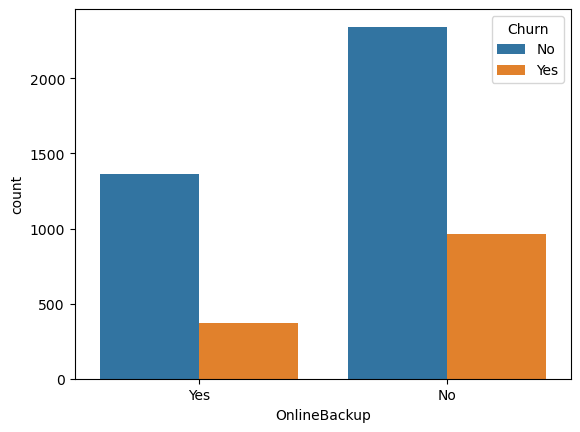

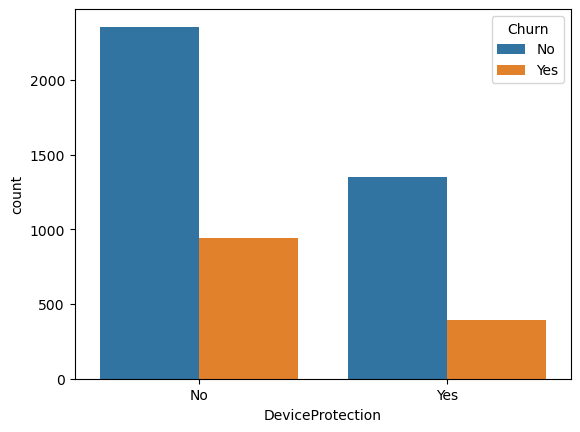

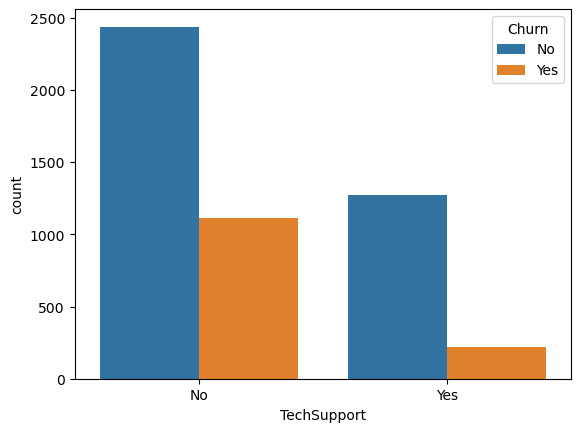

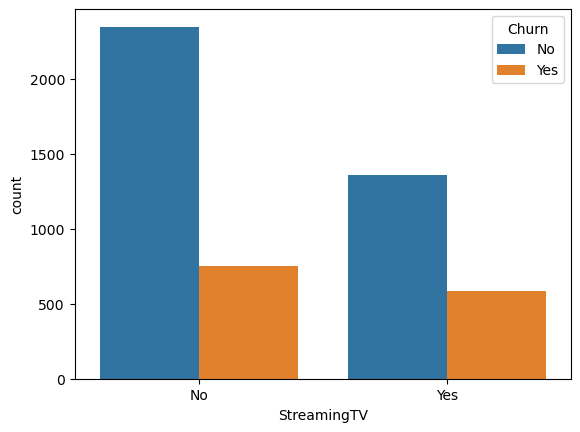

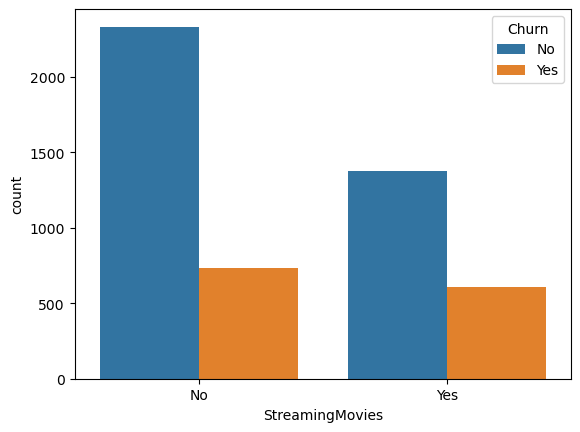

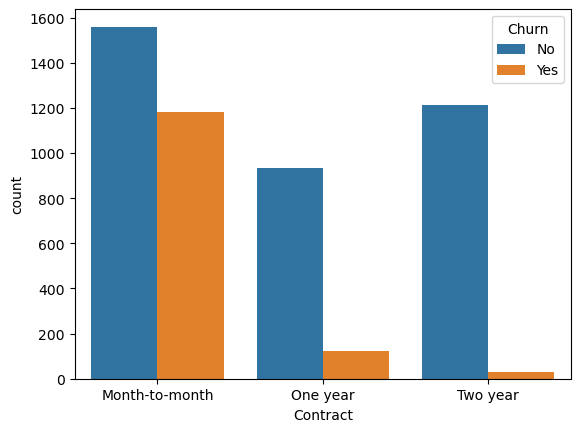

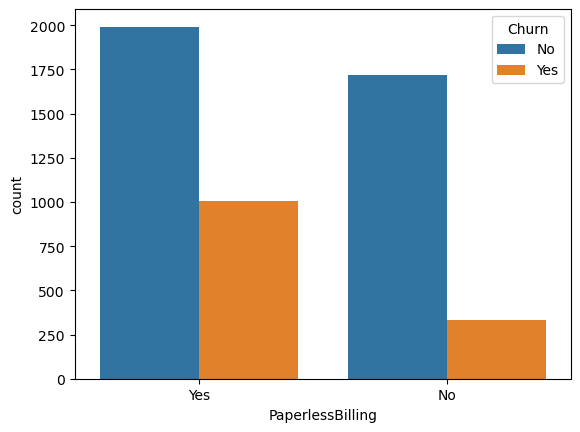

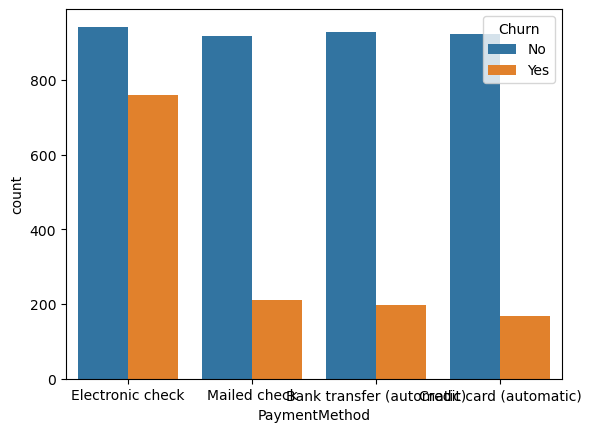

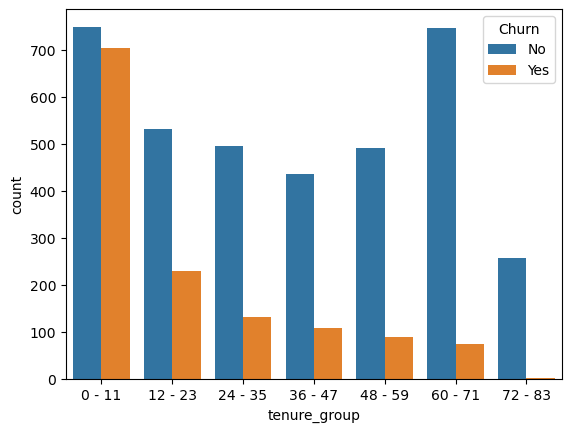

In [24]:
for i, predictor in enumerate(dataset.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges', 'tenure'])):
    plt.figure(i)
    sns.countplot(data=dataset, x=predictor, hue='Churn')

#### Insights derived from the bi-variate analysis;

1. Gender does not have a direct implication to whether a customer is likely to churn or not.
2. Customers with a longer tenure in the company are less likely to churn as compared to customers with a shorter tenure.
3. Customers with Electronic check as their mode of payment are likely to churn in comparison to those with the other payment modes
4. Customers with Month to Month contract are more likely to churn as compared to those with longer contract periods.
5. Customers with No internet service generally have a very low churn outcome.
6. Customers with phone service equally have a higher likelyhood of churning compared to theose without.
7. Customers without dependents are more likely to churn as compared to those with dependents


## Multi-variate Analysis

In [25]:
#create Countplot that we can customize for various data options.

def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()


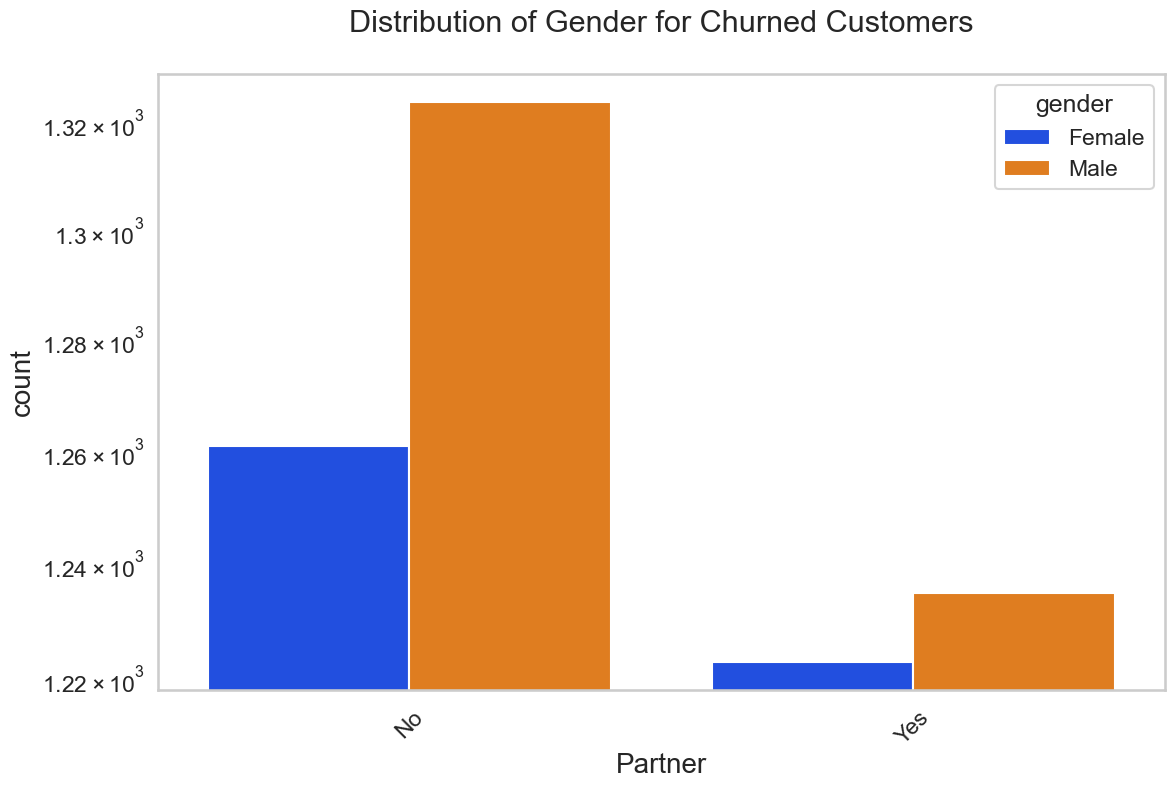

In [26]:
#Comparison between Gender, Partner and Churn.
uniplot(dataset,col='Partner',title='Distribution of Gender for Churned Customers',hue='gender')

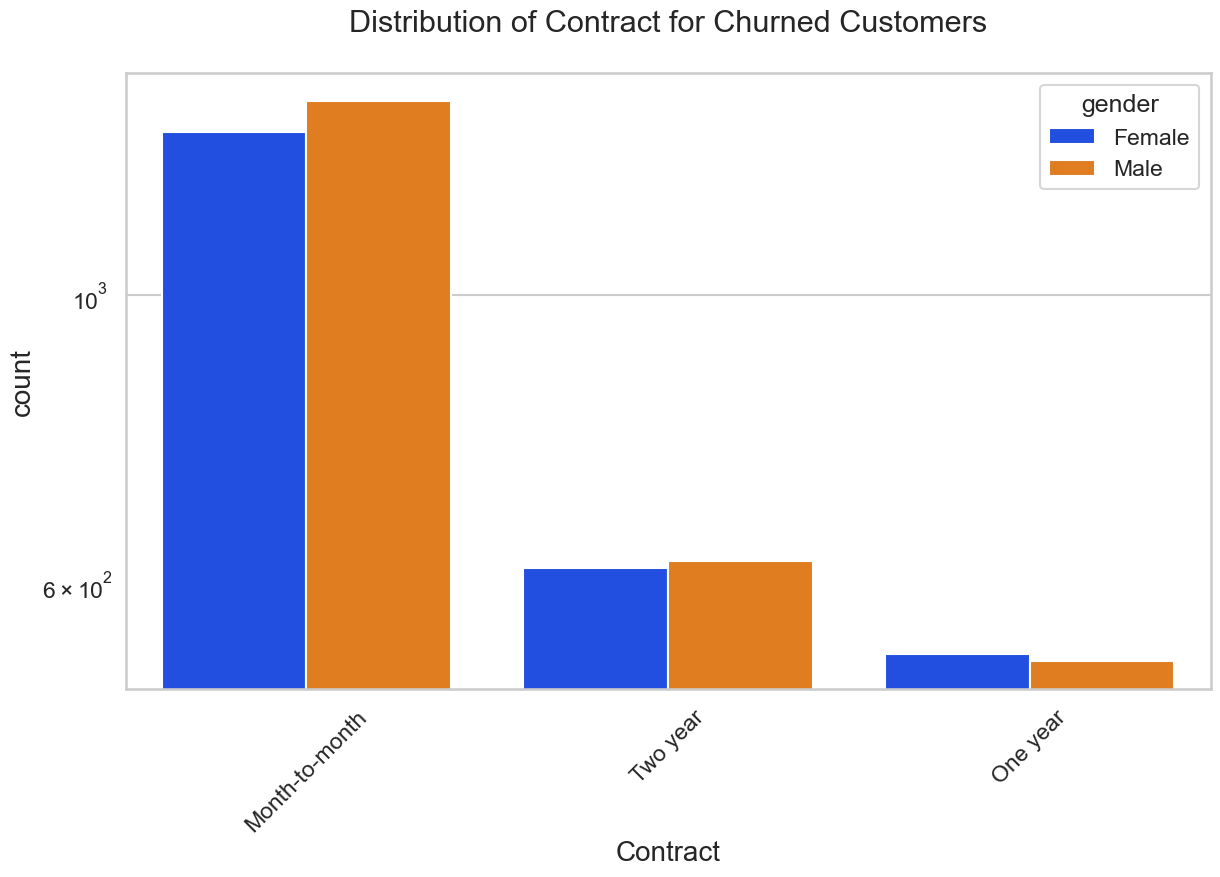

In [27]:
#Comparison between contrac type, Gender and Churn
uniplot(dataset,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')

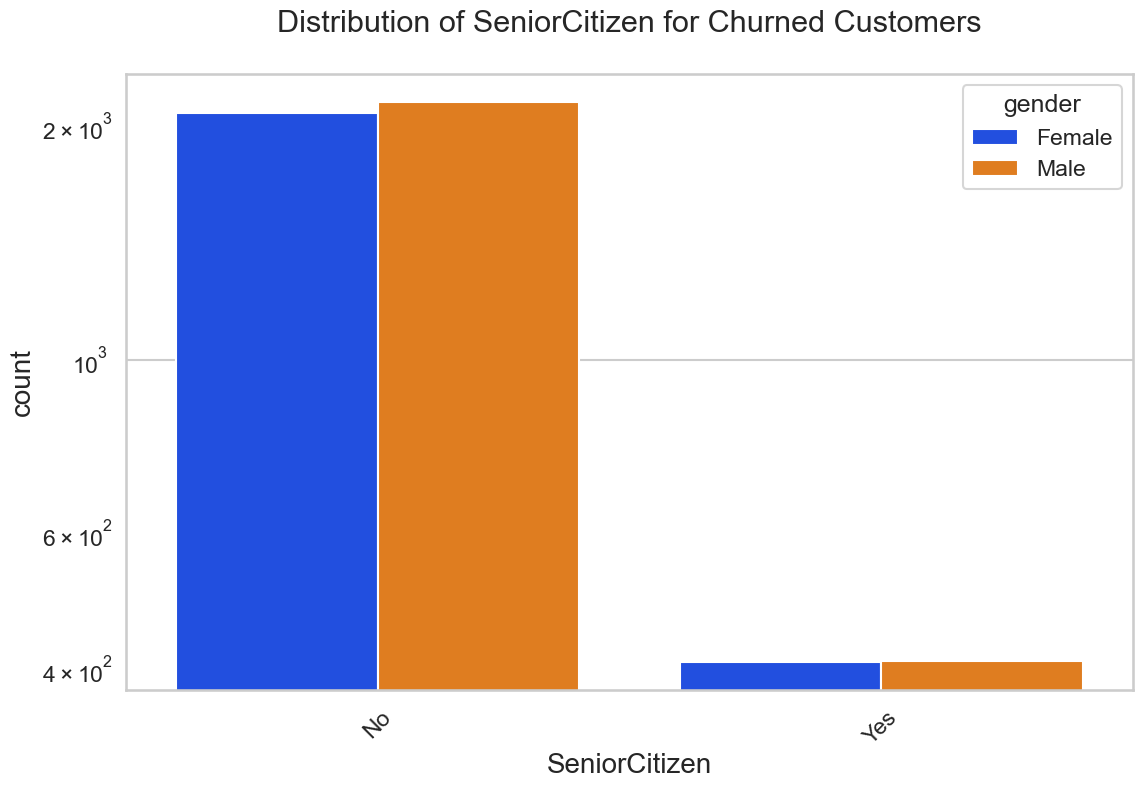

In [28]:
#Comparison between Senior citizen, Gender and Churn
uniplot(dataset,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')

### Insights Derived.
1. Customers who are not senior citizens churn higher regardless of the gender.
2. Customers with a monthly contract churn higher regardless of the gender.
3. Male customers with no partners have a higher tendency to churn.

## ANALYTICAL QUESTIONS.
1. What is the comparison of the number of customers who have churned against those who were retained.
2. Is there a relation between the contract type and the customer churn rate
3. What is the relation between the tenure and the churn for the customers
4. Is there a relation between gender and the churn rate
5. Does the customer having a partner and dependents affect the churn rate?
6. What is the longest period of time we have had a customer?


Question 1: What is the comparison of the number of customers who have churned against those who were retained.

In [29]:

# Get unique values in the 'Churn' column
churn_values = dataset['Churn'].unique()

# Calculate the churn ratio for each unique value
churn_ratios = {value: (dataset['Churn'] == value).mean() 
                for value in churn_values}

# Print the churn ratios
for value, ratio in churn_ratios.items():
    print(f"Churn Ratio for '{value}': {ratio:.2%}")

Churn Ratio for 'No': 73.51%
Churn Ratio for 'Yes': 26.49%


From the churn ratio  for churners to those who didnt churn, it is evident the data is not balanced.

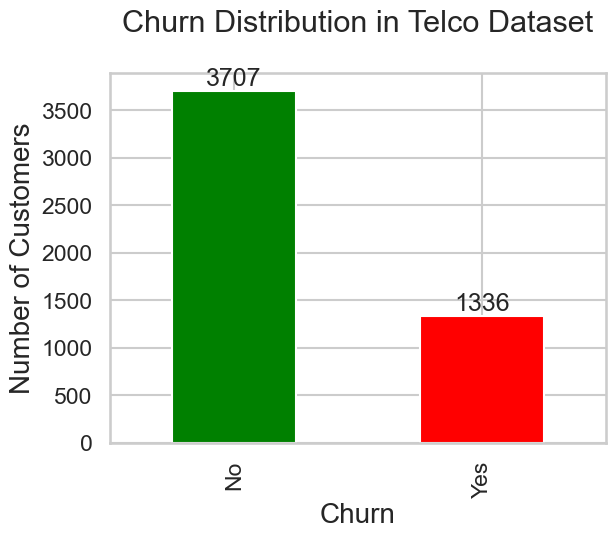

In [30]:
# Plot a bar graph for the 'Churn' column
churn_counts = dataset['Churn'].value_counts()
ax = churn_counts.plot(kind='bar', color=['green', 'red'])

# Set plot labels and title
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.title('Churn Distribution in Telco Dataset')
# Add value labels to each bar
for i, value in enumerate(churn_counts):
    ax.text(i, value + 5, str(value), ha='center', va='bottom')

# Display the plot
plt.show()

A total of 1336 customers churned while 3706 did not churn

Question 2: Is there a relation between the contract type and the customer churn rate

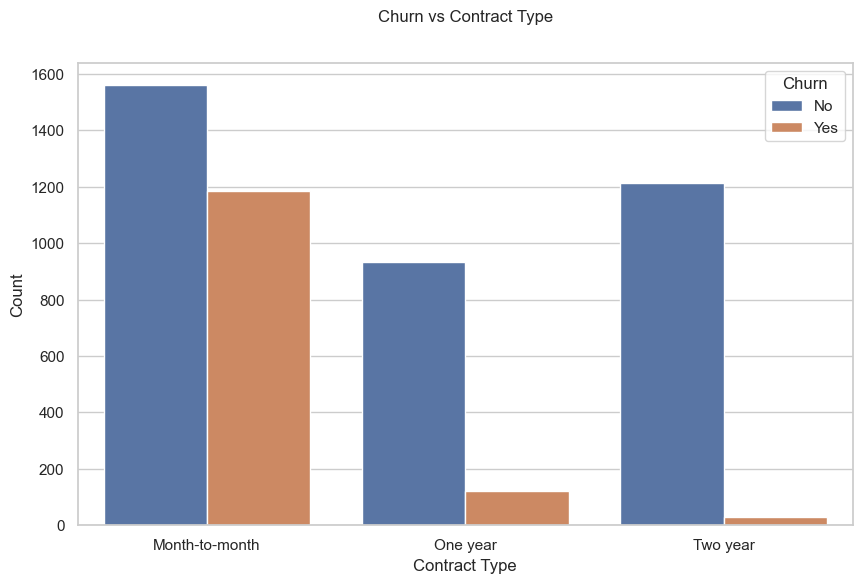

In [31]:
# Create a count plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.countplot(x='Contract', hue='Churn', data=dataset)


# Customize the plot
plt.title('Churn vs Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')

# Show the plot
plt.show()

It is evident that customers with a shorter contract period(Month-to-Month) have a high tendency to churn.

Question 3. What is the relation between the tenure and the churn for the customers

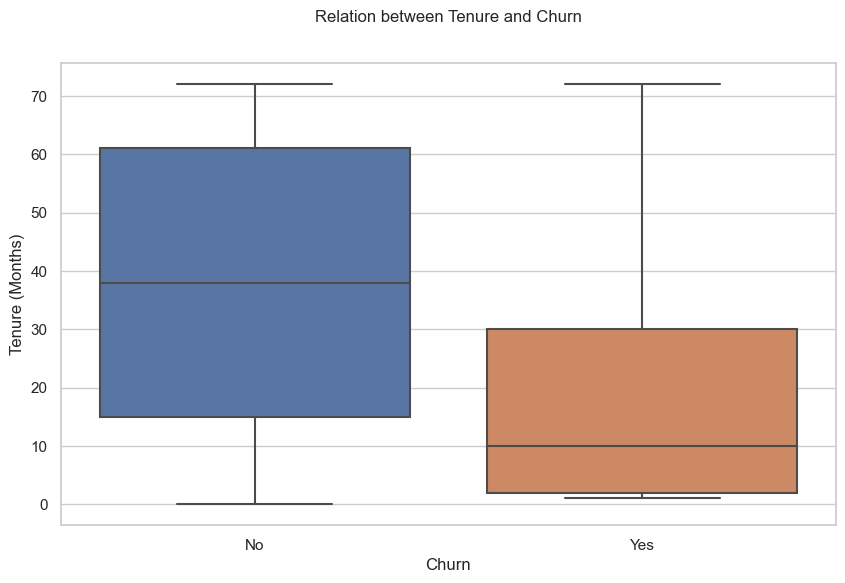

In [32]:
# Create a boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=dataset)

# Customize the plot
plt.title('Relation between Tenure and Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (Months)')

# Show the plot
plt.show()

Here, we see that the customers with a less tenure are more predominant in churning, with no outliers. 

Question 4. Is there a relationship between gender and churn.

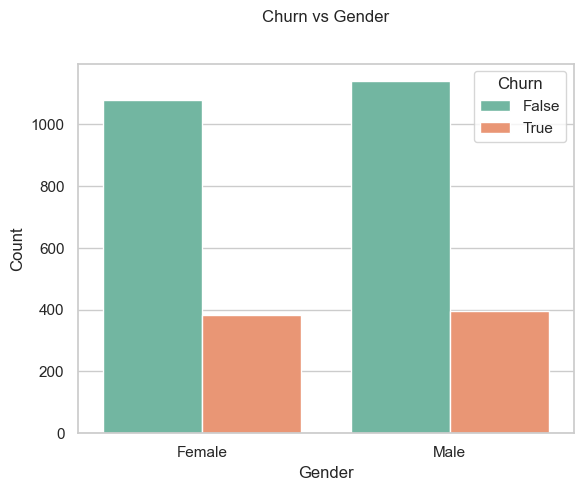

In [33]:
# Create a count plot
sns.countplot(x='gender', hue='Churn', data=dataset_1, palette="Set2")

# Customize the plot
plt.title('Churn vs Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')

# Show the plot
plt.show()

From this result, Gender is not a key factor in determining the churn for the customers.

Question 5. Does the customer having a partner and dependents affect the churn rate?

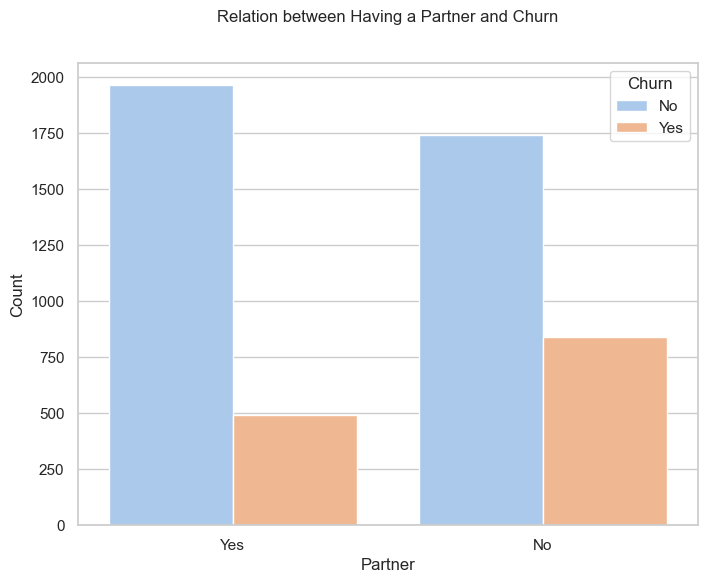

In [34]:
# Create a countplot using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='Partner', hue='Churn', data=dataset, palette='pastel')

# Customize the plot
plt.title('Relation between Having a Partner and Churn')
plt.xlabel('Partner')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')

# Show the plot
plt.show()


There is a very small relation between having a partner and churning, where the is a slightly higher rate of churn within customers without partners in comparison to those who have partners.

Question 6. What is the longest period of time we have had a customer?

In [35]:
# Find the highest value in the 'tenure' column
highest_tenure = dataset['tenure'].max()

# Print the result
print("The highest customer tenure is", highest_tenure, "months")

The highest customer tenure is 72 months


### The corelation Matrix of the variables in the dataset.

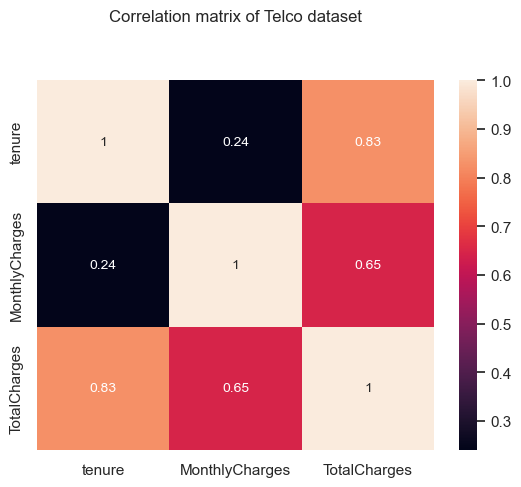

In [36]:
# Finding the correlation among the numeric variables.
numeric_columns = dataset.select_dtypes(include='number')
correlation = numeric_columns.corr()

# Plotting the heatmap
heatmap = sns.heatmap(correlation, annot=True, annot_kws={'size': 10})
heatmap.set_title("Correlation matrix of Telco dataset\n")
plt.show()

Hypothesis testing

In [37]:
# Create a contingency table
contingency_table = pd.crosstab(dataset['Contract'], dataset['Churn'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 882.0901975577578
P-value: 2.86119415951209e-192
Degrees of freedom: 2
Expected frequencies table:
[[2017.05492762  726.94507238]
 [ 775.50763434  279.49236566]
 [ 914.43743803  329.56256197]]


The P-value is 2.86119415951209e-192, which is less than 0.005, and thus we reject the null hypothesis.

## DATA PREPARATION

Dealing with missing values.

For categorical values, we will impute with the mode. For numerical values, we impute with the mean.

In [38]:

#Filling NAs in the MultipleLines with the mode of the column.
dataset['MultipleLines'] = dataset['MultipleLines'].fillna(dataset['MultipleLines'].mode()[0])
#Filling NAs in the OnlineSecurity with the mode of the column.
dataset['OnlineSecurity'] = dataset['OnlineSecurity'].fillna(dataset['OnlineSecurity'].mode()[0])
#Filling NAs in the OnlineBackup with the mode of the column.
dataset['OnlineBackup'] = dataset['OnlineBackup'].fillna(dataset['OnlineBackup'].mode()[0])
#Filling NAs in the DeviceProtection with the mode of the column.
dataset['DeviceProtection'] = dataset['DeviceProtection'].fillna(dataset['DeviceProtection'].mode()[0])
#Filling NAs in the Techsupport with the mode of the column.
dataset['TechSupport'] = dataset['TechSupport'].fillna(dataset['TechSupport'].mode()[0])
#Filling NAs in the StreamingTV with the mode of the column.
dataset['StreamingTV'] = dataset['StreamingTV'].fillna(dataset['StreamingTV'].mode()[0])
#Filling NAs in the StreamingMovies with the mode of the column.
dataset['StreamingMovies'] = dataset['StreamingMovies'].fillna(dataset['StreamingMovies'].mode()[0])
#Filling NAs in the TotalCharges with the mode of the column.
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean())
#Filling NAs in the TotalCharges with the mode of the column.
dataset['Churn'] = dataset['Churn'].fillna(dataset['Churn'].mode()[0])
#Filling NAs in the TotalCharges with the mode of the column.
#dataset['Tenre'] = dataset['Churn'].fillna(dataset['Churn'].mode()[0])

Relation for any missing values

<function matplotlib.pyplot.show(close=None, block=None)>

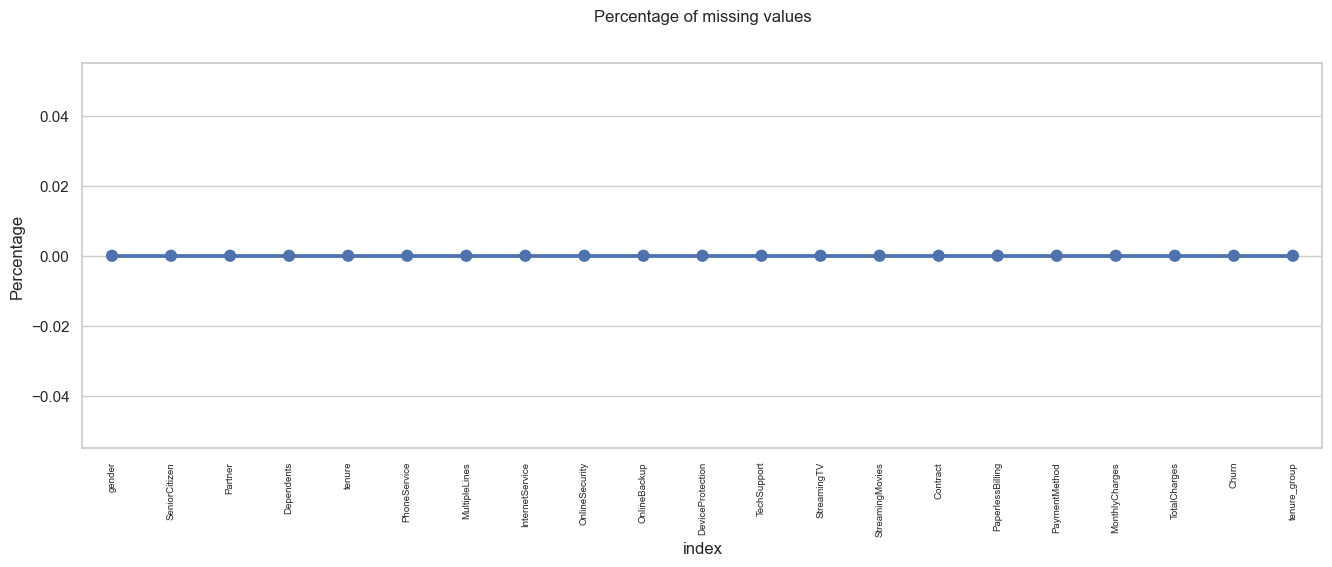

In [39]:
#Check for the percentage of null values for each column.
missing = pd.DataFrame((dataset.isnull().sum())*100/dataset.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index', y=0, data = missing)
plt.xticks(rotation = 90, fontsize = 7)
plt.title("Percentage of missing values")
plt.ylabel("Percentage")
plt.show

In [40]:
dataset['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [41]:
# Mapping 'Yes' to 1 and 'No' to 0 in the 'Churn' column
dataset['Churn'] = dataset['Churn'].map({'Yes': 1, 'No': 0})
#Using the astype(int) to convert the boolean values into integers.
dataset['Churn'] = dataset['Churn'].astype(int)

In [42]:

# Extracting numerical columns
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Standardization
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# Normalization
minmax_scaler = MinMaxScaler()
dataset[numerical_columns] = minmax_scaler.fit_transform(dataset[numerical_columns])

# Log Transformation
dataset[numerical_columns] = dataset[numerical_columns].apply(lambda x: np.log1p(x) if x.name in ['MonthlyCharges', 'TotalCharges'] else x)

In [43]:
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

# Convert categorical columns to dummy variables
dummy_columns = pd.get_dummies(dataset[categorical_columns])

# Concatenate the dummy columns with the original DataFrame
dataset = pd.concat([dataset, dummy_columns], axis=1)

# Drop the original categorical columns
dataset = dataset.drop(categorical_columns, axis=1)



In [44]:
print(dataset.columns)

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_group',
       'gender_Female', 'gender_Male', 'SeniorCitizen_No', 'SeniorCitizen_Yes',
       'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes',
       'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_Yes', 'InternetService_No', 'InternetService_Yes',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [45]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   tenure                                   5043 non-null   float64 
 1   MonthlyCharges                           5043 non-null   float64 
 2   TotalCharges                             5043 non-null   float64 
 3   Churn                                    5043 non-null   int32   
 4   tenure_group                             5043 non-null   category
 5   gender_Female                            5043 non-null   bool    
 6   gender_Male                              5043 non-null   bool    
 7   SeniorCitizen_No                         5043 non-null   bool    
 8   SeniorCitizen_Yes                        5043 non-null   bool    
 9   Partner_No                               5043 non-null   bool    
 10  Partner_Yes                         

Split the data into two X and Y

In [46]:
#Split the data to remove the target variable(Churn column)
x = dataset.drop('Churn', axis=1)
x.head()

,tenure,MonthlyCharges,TotalCharges,tenure_group,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.013889,0.108150,0.001276,0 - 11,True,False,True,False,False,True,...,False,True,False,False,False,True,False,False,True,False
1,0.472222,0.325367,0.195759,24 - 35,False,True,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True
2,0.027778,0.302779,0.010275,0 - 11,False,True,True,False,True,False,...,False,True,False,False,False,True,False,False,False,True
3,0.625000,0.213823,0.191115,36 - 47,False,True,True,False,True,False,...,False,False,True,False,True,False,True,False,False,False
4,0.027778,0.419825,0.015239,0 - 11,True,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False


In [47]:
#Define the target variable(churn)
y=dataset['Churn']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int32

Train Test Split

In [48]:
#Split dataset into training and testing sets. (This splits the data into 20% for test, and 80% train)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

### Feature Engineering

In [49]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   tenure                                   5043 non-null   float64 
 1   MonthlyCharges                           5043 non-null   float64 
 2   TotalCharges                             5043 non-null   float64 
 3   tenure_group                             5043 non-null   category
 4   gender_Female                            5043 non-null   bool    
 5   gender_Male                              5043 non-null   bool    
 6   SeniorCitizen_No                         5043 non-null   bool    
 7   SeniorCitizen_Yes                        5043 non-null   bool    
 8   Partner_No                               5043 non-null   bool    
 9   Partner_Yes                              5043 non-null   bool    
 10  Dependents_No                       

In [50]:
numeric_columns= x.select_dtypes(include='number')
numeric_columns

,tenure,MonthlyCharges,TotalCharges
0,0.013889,0.108150,0.001276
1,0.472222,0.325367,0.195759
2,0.027778,0.302779,0.010275
3,0.625000,0.213823,0.191115
4,0.027778,0.419825,0.015239
...,...,...,...
5038,0.333333,0.508229,0.205312
5039,1.000000,0.612959,0.614592
5040,0.152778,0.105909,0.037173
5041,0.055556,0.443790,0.032725


In [51]:
categorical_columns= x.select_dtypes(include='object')
categorical_columns

""
0
1
2
3
4
...
5038
5039
5040
5041


In [52]:
from sklearn.compose import ColumnTransformer
# Separating input features into numeric and categorical for different pipelines
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object']).columns

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson'))
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Combine preprocessing and classifier in a single pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier())]) 


In [53]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   tenure                                   5043 non-null   float64 
 1   MonthlyCharges                           5043 non-null   float64 
 2   TotalCharges                             5043 non-null   float64 
 3   tenure_group                             5043 non-null   category
 4   gender_Female                            5043 non-null   bool    
 5   gender_Male                              5043 non-null   bool    
 6   SeniorCitizen_No                         5043 non-null   bool    
 7   SeniorCitizen_Yes                        5043 non-null   bool    
 8   Partner_No                               5043 non-null   bool    
 9   Partner_Yes                              5043 non-null   bool    
 10  Dependents_No                       

In [54]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

K-Nearest Neighbor Classifier

In [55]:

# Create a KNN classifier
model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])

# Fit the model to the training data
model_1.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

Logistic Regression Classifier

In [56]:

# Creating a Logistic Regression classifier
model_2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

# Fit the model to the training data
model_2.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', LogisticRegression())])

Random Forest Classifier

In [57]:

# Create a Random Forest classifier
model_3 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

# Fit the model to the training data
model_3.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

Decision Tree Model

In [58]:
#Creation and fiting of the decision tree model.
model_4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model_4.fit(x_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power_transformer',
                                                                   PowerTransformer())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

Model Report for the above models:

In [59]:

# Evaluate Model 1
y_pred_1 = model_1.predict(x_test)

# Classification Report
print("Model 1 Metrics:")
print(classification_report(y_test, y_pred_1))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_1))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_1))



Model 1 Metrics:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       734
           1       0.58      0.49      0.53       275

    accuracy                           0.77      1009
   macro avg       0.70      0.68      0.69      1009
weighted avg       0.76      0.77      0.76      1009

Confusion Matrix:
[[638  96]
 [140 135]]
Accuracy: 0.7661050545094152


In [60]:
# Evaluate Model 2
y_pred_2 = model_2.predict(x_test)

# Classification Report
print("Model 2 Metrics:")
print(classification_report(y_test, y_pred_2))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_2))

# Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy_2)

Model 2 Metrics:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       734
           1       0.67      0.43      0.52       275

    accuracy                           0.79      1009
   macro avg       0.74      0.67      0.69      1009
weighted avg       0.77      0.79      0.77      1009

Confusion Matrix:
[[677  57]
 [158 117]]
Accuracy: 0.7869177403369673


In [61]:
# Evaluate Model 3
y_pred_2 = model_3.predict(x_test)

# Classification Report
print("Model 2 Metrics:")
print(classification_report(y_test, y_pred_2))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_2))

# Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy_2)

Model 2 Metrics:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       734
           1       0.53      0.42      0.47       275

    accuracy                           0.74      1009
   macro avg       0.67      0.64      0.65      1009
weighted avg       0.73      0.74      0.73      1009

Confusion Matrix:
[[632 102]
 [159 116]]
Accuracy: 0.7413280475718533


In [62]:
# Evaluate Model 4
y_pred_2 = model_4.predict(x_test)

# Classification Report
print("Model 2 Metrics:")
print(classification_report(y_test, y_pred_2))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_2))

# Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy_2)

Model 2 Metrics:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       734
           1       0.44      0.45      0.45       275

    accuracy                           0.70      1009
   macro avg       0.62      0.62      0.62      1009
weighted avg       0.70      0.70      0.70      1009

Confusion Matrix:
[[578 156]
 [151 124]]
Accuracy: 0.6957383548067394


From the above model scores, Model 2(Logistic regression Classifier) has the highest F1-score of 0.86 and as such the best model to be employed. The accuracy of the model is at 78% and this could be attributed to the imbalanced data set.

Balancing the dataset.

In [63]:
sm = SMOTEENN()
X_resampled1, y_resampled1 = sm.fit_sample(x,y)

NameError: name 'SMOTEENN' is not defined